# Metrics

In [1]:
import joblib
import scFocus
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

cm = 1/2.54
sc.set_figure_params(figsize=(5*cm,5*cm),dpi=300,fontsize=10,frameon=False)

pal = sns.color_palette('tab10', n_colors=4)

In [36]:
from sklearn.metrics.pairwise import cosine_similarity, rbf_kernel

In [2]:
paul = joblib.load('Paul')

In [8]:
f1 = paul.obsm['X_tsne']

focus1 = scFocus.focus(f1, n=6, max_steps=3).meta_focusing(3)

Meta fitting... 7: 100%|██████████████████████████████████| 100/100 [00:11<00:00,  9.09it/s, E=700, R=-42.40, S=121.18]


Converged at iteration 7. Training stopped!
Meta fitting time used: 75.24 seconds


Focus fitting...: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.47it/s]


Focus fitting time used: 0.96 seconds


Meta fitting... 7: 100%|██████████████████████████████████| 100/100 [00:10<00:00,  9.61it/s, E=700, R=-44.99, S=122.75]


Converged at iteration 7. Training stopped!
Meta fitting time used: 73.41 seconds


Focus fitting...:  30%|███████████████████▌                                             | 3/10 [00:00<00:00,  9.00it/s]


Focus fitting time used: 0.34 seconds


Meta fitting... 7: 100%|██████████████████████████████████| 100/100 [00:10<00:00,  9.66it/s, E=700, R=-42.70, S=121.92]


Converged at iteration 7. Training stopped!
Meta fitting time used: 71.37 seconds


Focus fitting...: 100%|████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.96it/s]

Focus fitting time used: 0.85 seconds
Meta focusing time used: 222.18 seconds


In [9]:
focus1.merge_fp2()

mfp = focus1.mfp[0]

for i in range(mfp.shape[1]):
    
    paul.obs[f'f{i}_tsne'] = mfp[:, i]

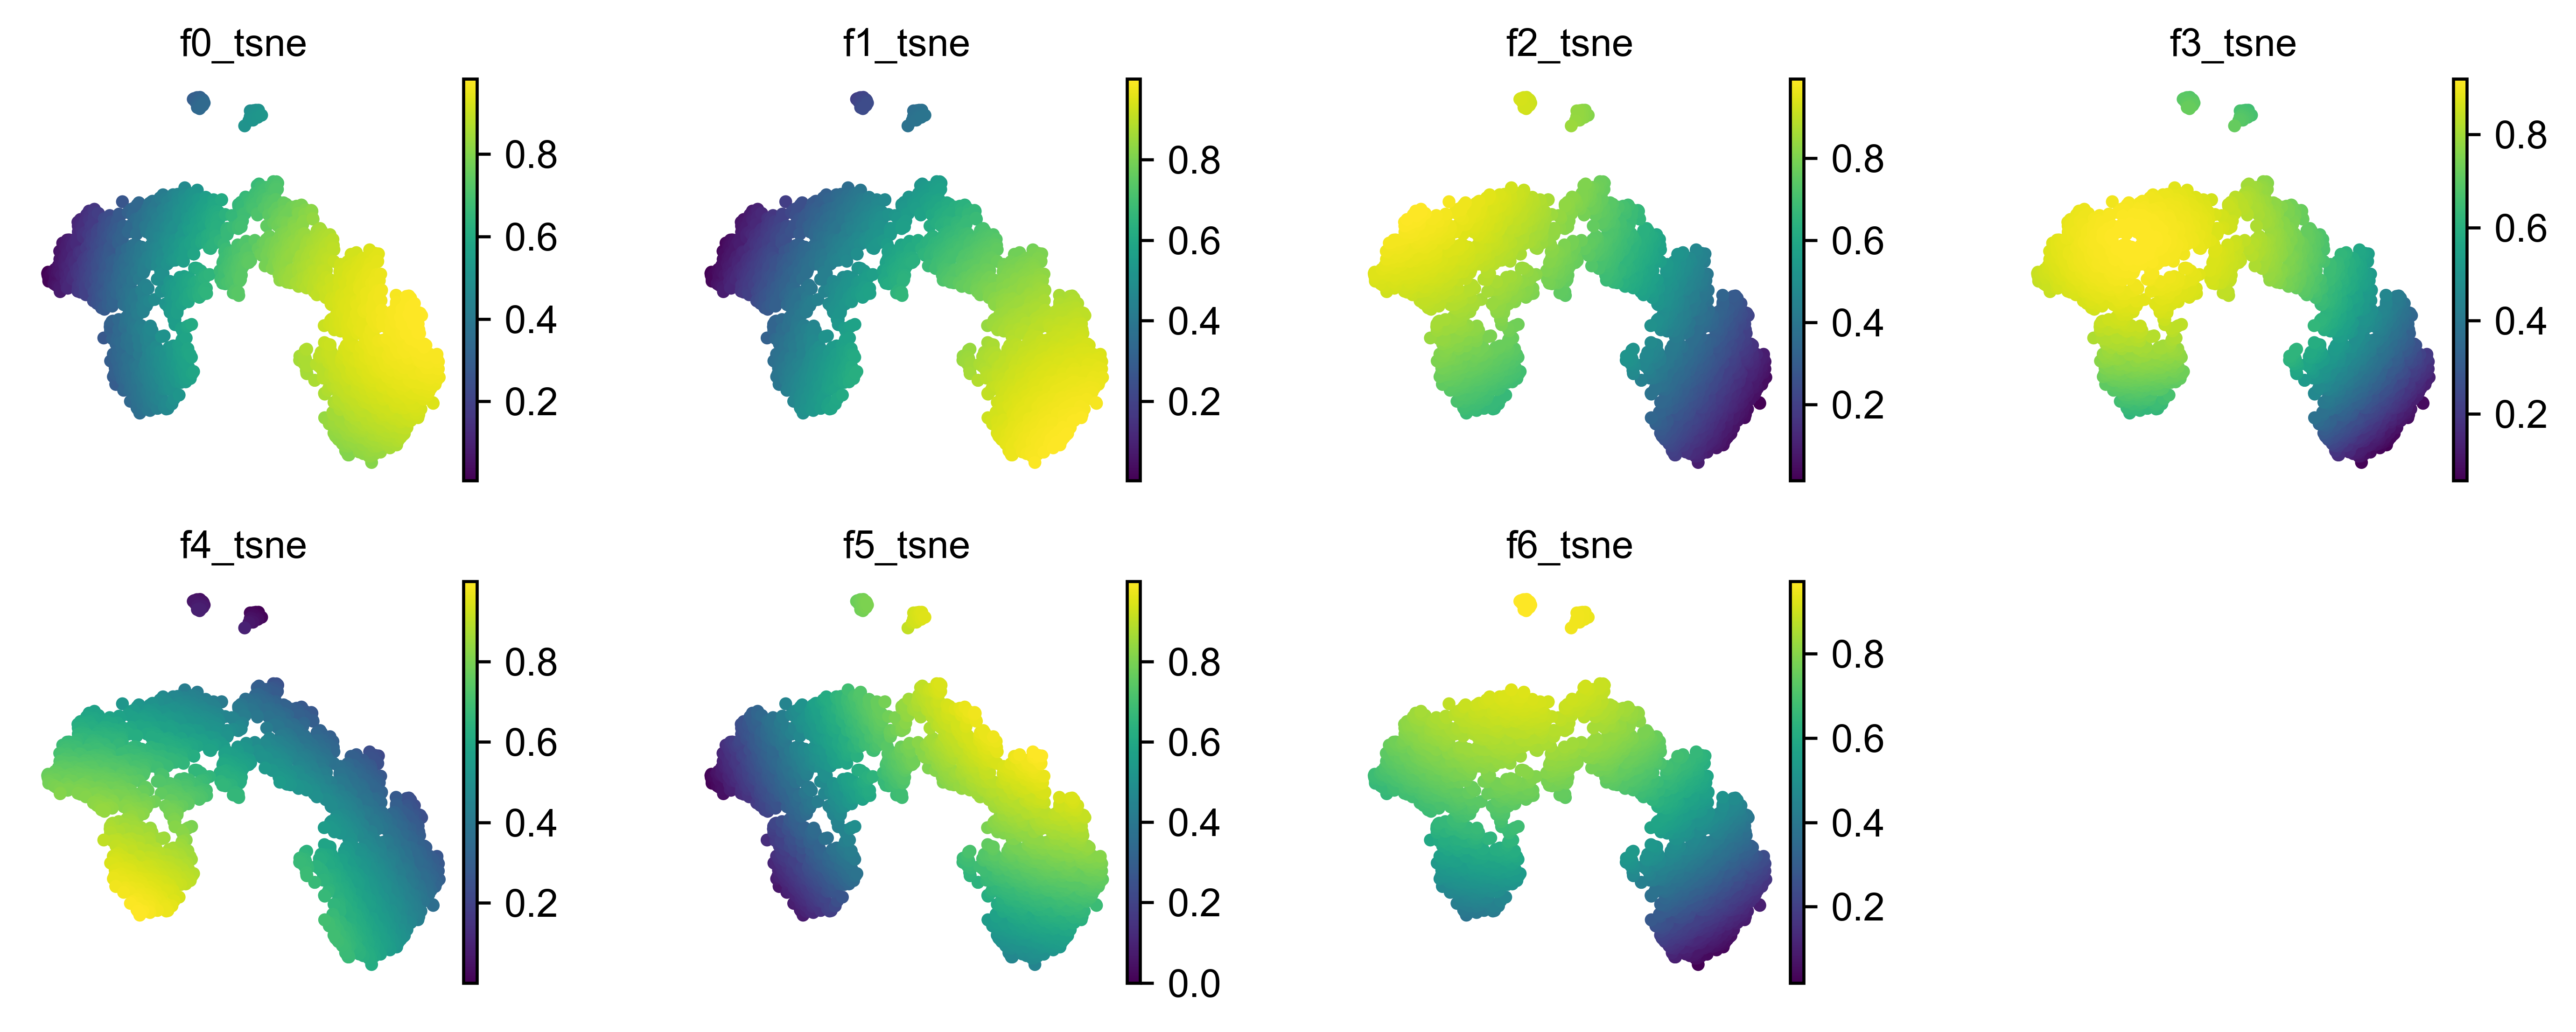

In [11]:
sc.pl.tsne(paul, color=[f'f{i}_tsne' for i in range(mfp.shape[1])])

In [12]:
def moving_average(a, window_size):
    """MA function for the reinforcement learning training process"""
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

In [19]:
for r in focus1.r:
    m = min(r.shape[0], np.inf)

r = np.vstack([r[:m] for r in focus1.r])
sigma = r.std(axis=0)
mu = r.mean(axis=0)

mu = moving_average(moving_average(mu, 251), 251)
sigma = moving_average(moving_average(sigma, 251), 251)

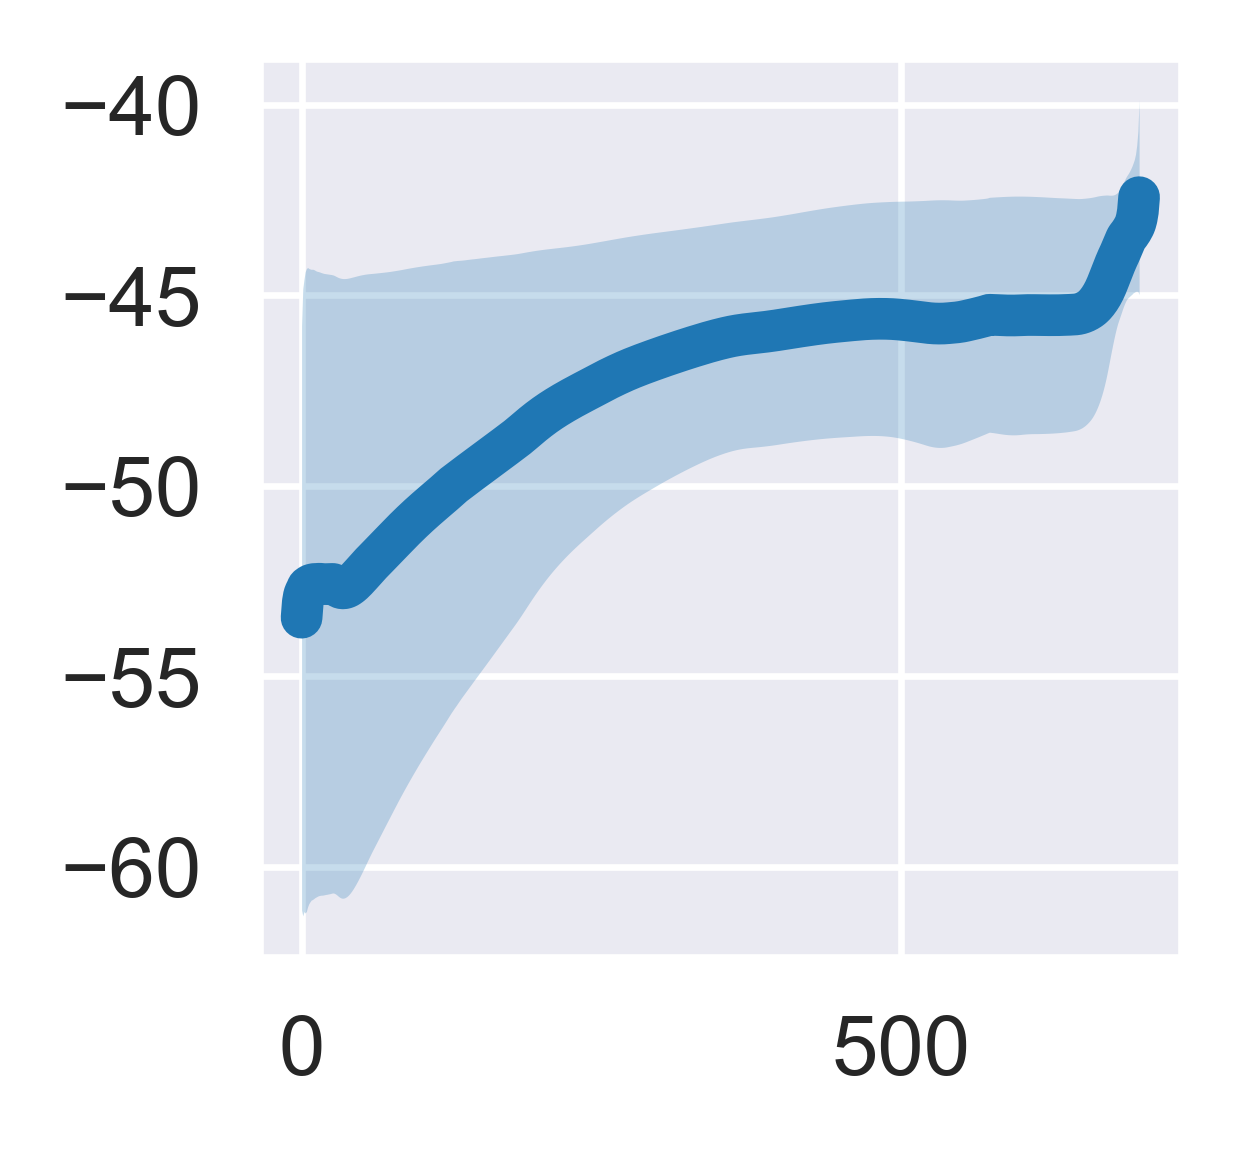

In [20]:
with sns.axes_style('darkgrid'):
    plt.plot(mu, lw=5, color=pal[0])
    plt.fill_between(np.arange(m),mu-sigma, mu+sigma, alpha=.25, color=pal[0], lw=0)
    plt.savefig('tsne-PaulCurve_r.png', dpi=1000, bbox_inches='tight')

In [15]:
for r in focus1.e:
    m = min(r.shape[0], np.inf)

r = np.vstack([r[:m] for r in focus1.e])
sigma = r.std(axis=0)
mu = r.mean(axis=0)

mu = moving_average(moving_average(mu, 251), 251)
sigma = moving_average(moving_average(sigma, 251), 251)

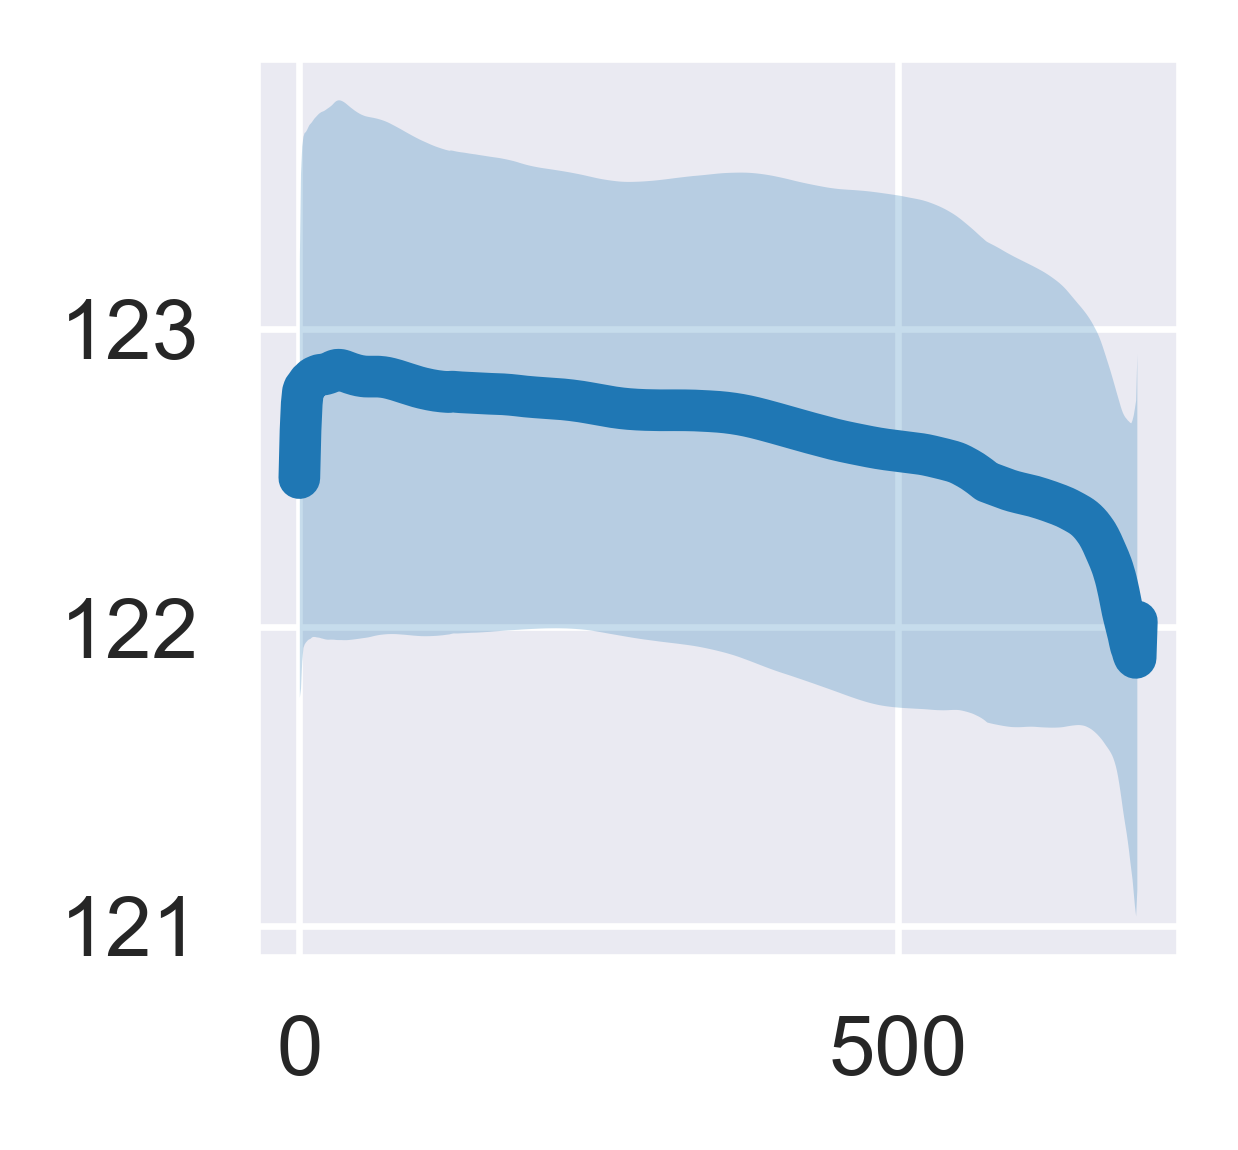

In [18]:
with sns.axes_style('darkgrid'):
    plt.plot(mu, lw=5, color=pal[0])
    plt.fill_between(np.arange(m),mu-sigma, mu+sigma, alpha=.25, color=pal[0], lw=0)
    plt.savefig('tsne-PaulCurve_e.png', dpi=1000, bbox_inches='tight')

In [22]:
paul.obsm['X_tsne_focus'] = mfp

In [72]:
sc.tl.tsne(paul, use_rep='X_tsne_focus')

In [92]:
from sklearn.preprocessing import minmax_scale

In [82]:
f1 = paul.obsm['X_pca'][:,:mfp.shape[1]]

In [95]:
f1 = minmax_scale(f1)

In [96]:
f2 = mfp

In [97]:
df1 = pd.DataFrame(f1)

df1['clusters'] = paul.obs['leiden'].values

df1 = pd.DataFrame({'S':df1.groupby('clusters').apply(lambda x:x.std(axis=0).sum())})

df1['type'] = 't-SNE'

df2 = pd.DataFrame(f2)

df2['clusters'] = paul.obs['leiden'].values

df2 = pd.DataFrame({'S':df2.groupby('clusters').apply(lambda x:x.std(axis=0).sum())})

df2['type'] = 'scFocus'

df = pd.concat([df1, df2], axis=0)

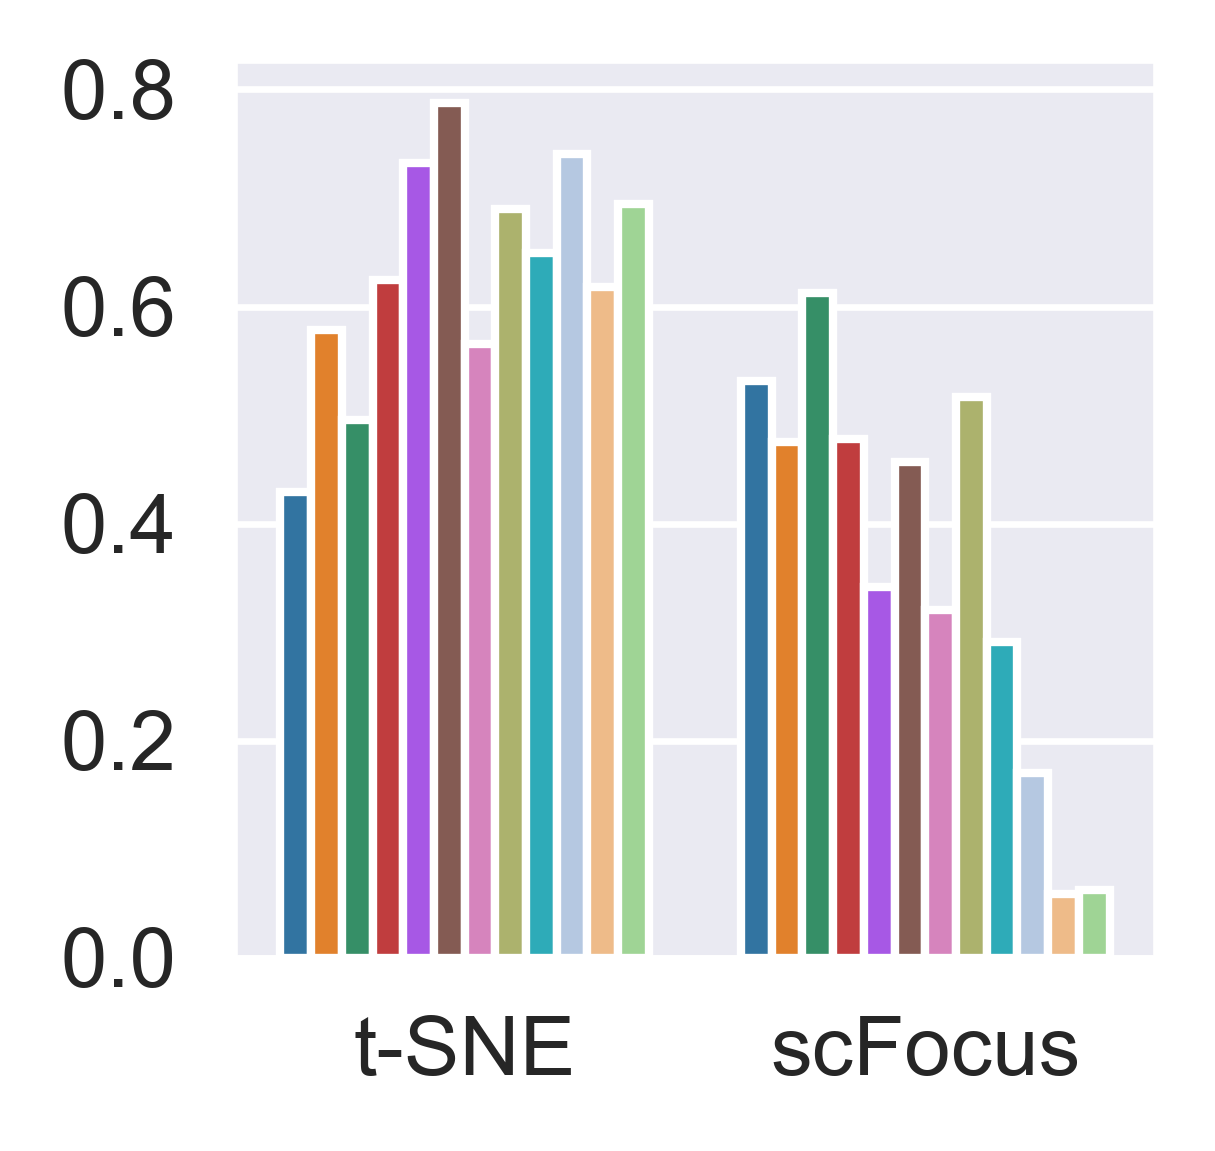

In [98]:
with sns.axes_style('darkgrid'):
    sns.barplot(data=df,x='type', y='S', hue=df.index, palette=paul.uns['leiden_colors'],legend=False)
    ax = plt.gca()
    ax.set_ylabel('')
    ax.set_xlabel('')

In [99]:
df1 = pd.DataFrame(rbf_kernel(f1)).melt()

df1['leiden'] = df1['variable'].astype('str').map(dict(paul.obs['leiden']))

df1 = df1.groupby('leiden').mean().loc[paul.obs['leiden'].cat.categories,:]

df1['type'] = 't-SNE'

df2 = pd.DataFrame(rbf_kernel(f2)).melt()

df2['leiden'] = df2['variable'].astype('str').map(dict(paul.obs['leiden']))

df2 = df2.groupby('leiden').mean().loc[paul.obs['leiden'].cat.categories,:]

df2['type'] = 'scFocus'

df = pd.concat([df1, df2], axis=0)

In [166]:
rbf = cosine_similarity(f1)

ls1 = []

for L in paul.obs['leiden'].cat.categories:
    mask = paul.obs['leiden'].values == L
    ls1.append(rbf[mask, :][:, mask].mean())



rbf = cosine_similarity(f2)

ls2 = []

for L in paul.obs['leiden'].cat.categories:
    mask = paul.obs['leiden'].values == L
    ls2.append(rbf[mask, :][:, mask].mean())


df1 = pd.DataFrame(ls1)
df1['type'] = 'PCA'
df2 = pd.DataFrame(ls2)
df2['type'] = 'scFocus'
df = pd.concat([df1, df2], axis=0)

In [163]:
rbf = rbf_kernel(f1)

ls1 = []

for L in paul.obs['leiden'].cat.categories:
    mask = paul.obs['leiden'].values == L
    ls1.append(rbf[mask, :][:, mask].mean())

rbf = rbf_kernel(f2)

ls2 = []

for L in paul.obs['leiden'].cat.categories:
    mask = paul.obs['leiden'].values == L
    ls2.append(rbf[mask, :][:, mask].mean())

In [164]:
df1 = pd.DataFrame(ls1)
df1['type'] = 'PCA'
df2 = pd.DataFrame(ls2)
df2['type'] = 'scFocus'
df = pd.concat([df1, df2], axis=0)

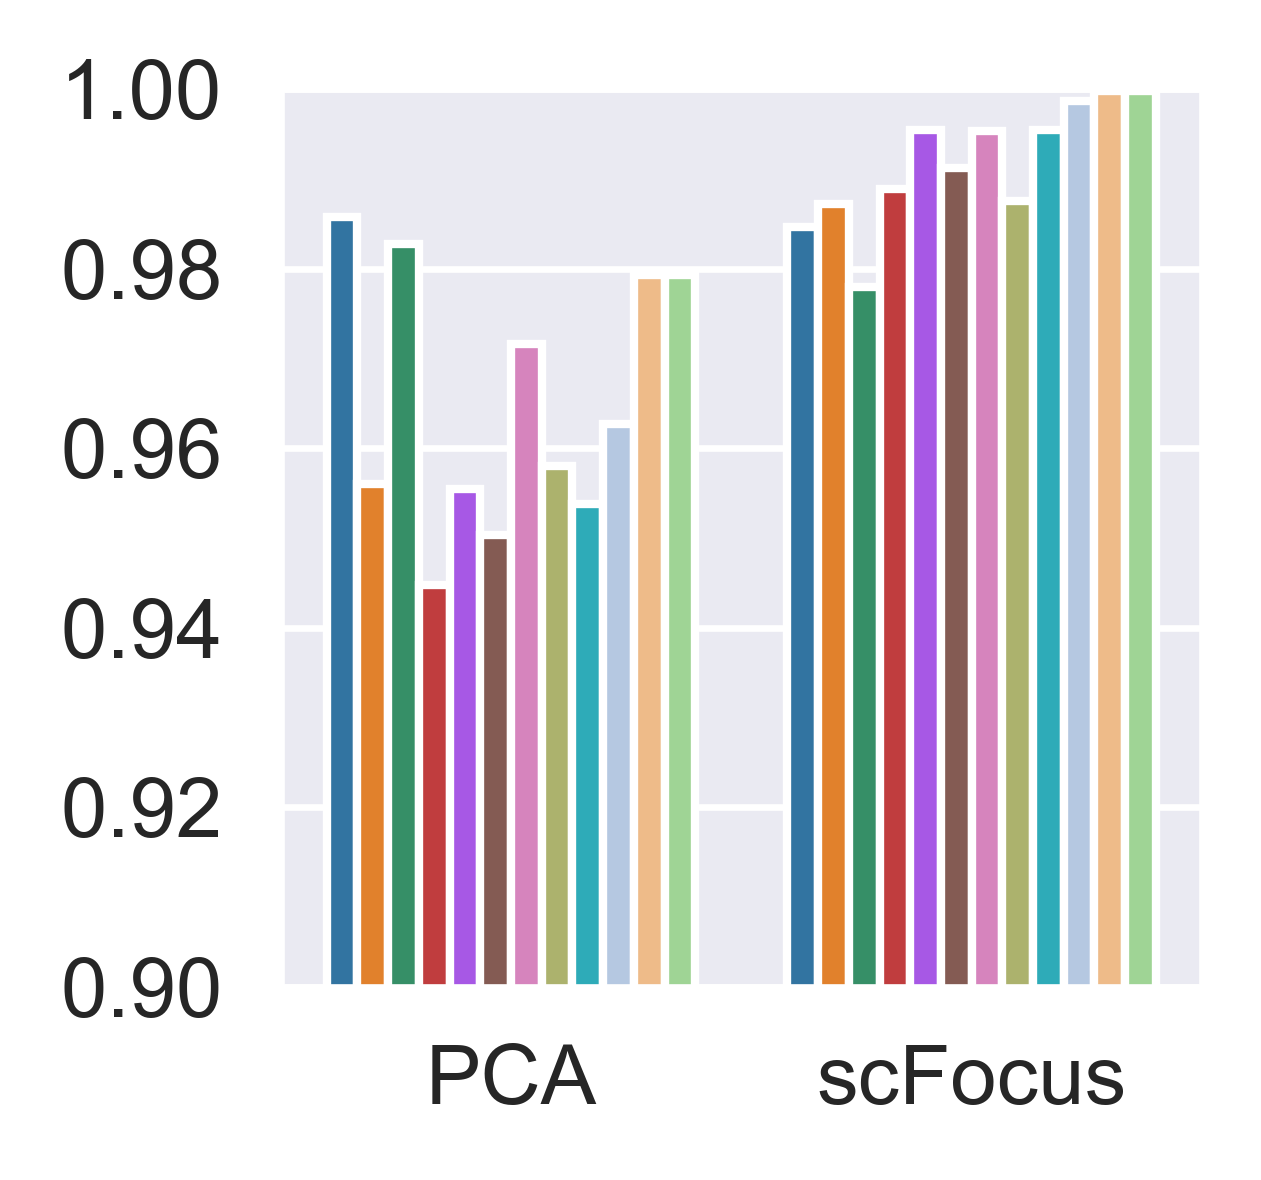

In [167]:
with sns.axes_style('darkgrid'):
    sns.barplot(x=df['type'], y=abs(df[0]), hue=df.index, palette=paul.uns['leiden_colors'],legend=False)
    ax = plt.gca()
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_ylim(.9, 1)

In [101]:
df1 = pd.DataFrame(cosine_similarity(f1)).melt()

df1['leiden'] = df1['variable'].astype('str').map(dict(paul.obs['leiden']))

df1 = df1.groupby('leiden').mean().loc[paul.obs['leiden'].cat.categories,:]

df1['type'] = 't-SNE'

df2 = pd.DataFrame(cosine_similarity(f2)).melt()

df2['leiden'] = df2['variable'].astype('str').map(dict(paul.obs['leiden']))

df2 = df2.groupby('leiden').mean().loc[paul.obs['leiden'].cat.categories,:]

df2['type'] = 'scFocus'

df = pd.concat([df1, df2], axis=0)

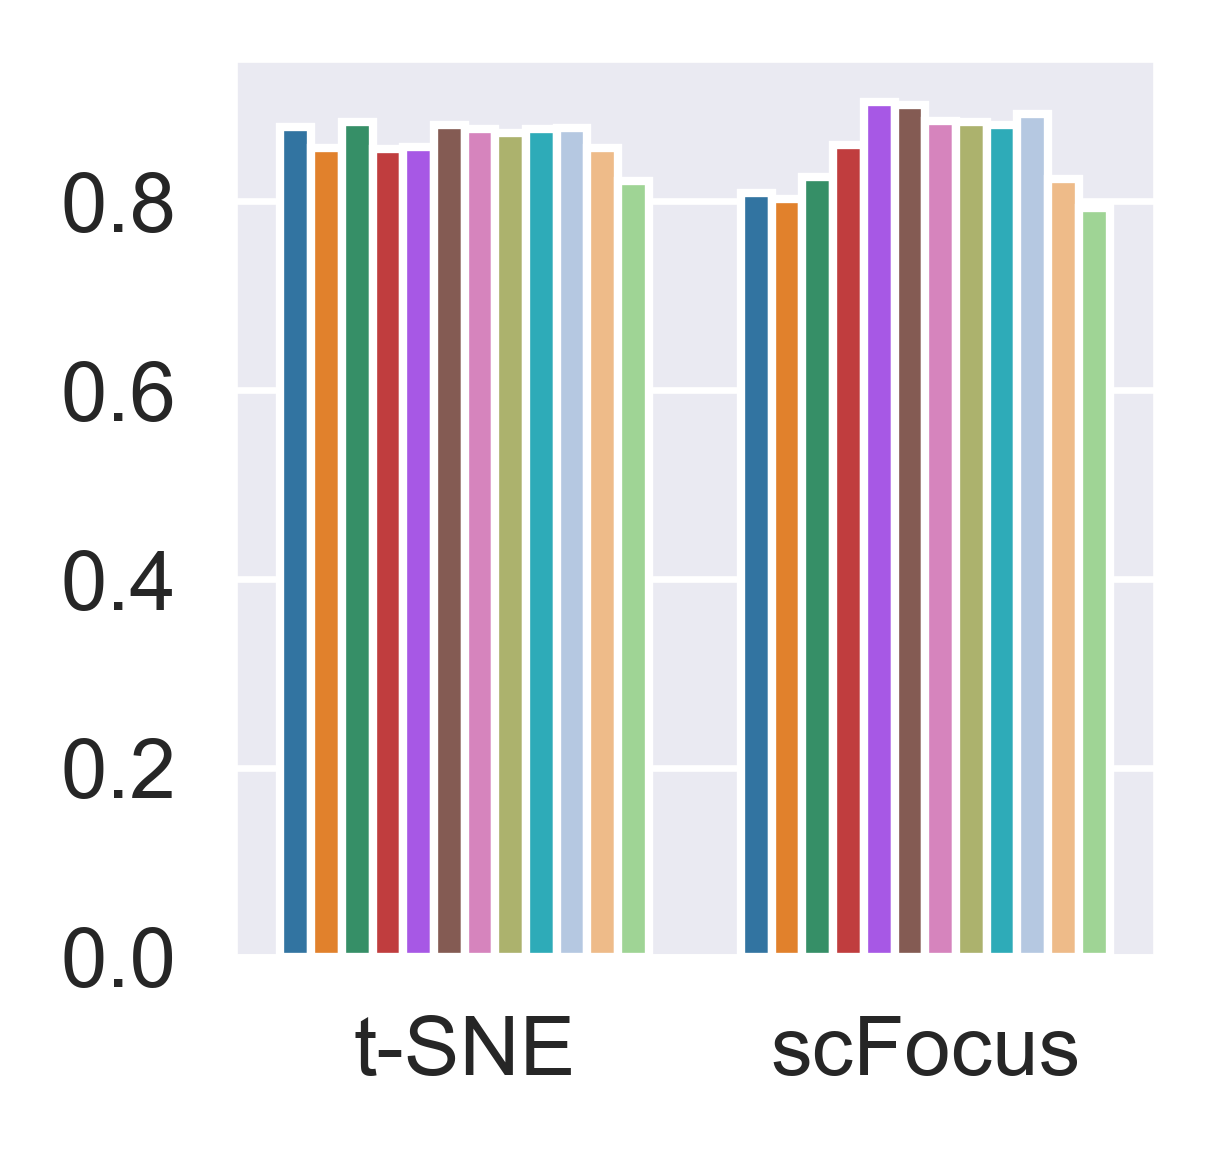

In [102]:
with sns.axes_style('darkgrid'):
    sns.barplot(x=df['type'], y=abs(df['value']), hue=df.index, palette=paul.uns['leiden_colors'],legend=False)
    ax = plt.gca()
    ax.set_ylabel('')
    ax.set_xlabel('')